In [10]:
%matplotlib inline

import numpy as np
import scipy.stats as stats
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import nibabel as nib
import sys
from nilearn import plotting, regions, image

In [11]:
def get_sublist(subDir):
    """ Lists all directories in a main directories of all subjects to create a subject list. Note that this is BIDS format specific (assumes all subject directories begin "sub-xxx". Could be modified.
 Return: subject list """
    sublist = []
    for subnum in np.sort(os.listdir(subDir)): 
        if subnum[0:3] == 'sub': 
            if not 'html' in subnum: 
                sublist.append(subnum.split('-')[1]) 
    return sublist 

def get_seslist(subDir, sub):
    """ Lists all directories in a main directories of all subjects to create a subject list. Note that this is BIDS format specific (assumes all subject directories begin "sub-xxx". Could be modified.
 Return: subject list """
    seslist = []
    ses_topDir = os.path.join(subDir, 'sub-%s' %(sub))
    for sesnum in np.sort(os.listdir(ses_topDir)): 
        if sesnum[0:3] == 'ses': 
            seslist.append(sesnum.split('-')[1]) 
    return seslist 

In [16]:
def load_nifti3D(filename):
    """ This function loads a 3D nifti file, converts it to a 3D array, and outputs the array matrix. Note that if you attempt to load a 4D nifti file this function will not work. """

    out=nib.load(filename)
    out_array=np.array(out.get_data())
    if len(out_array.shape)==4:
        # Since should be a 3D file, check that 4th dimension is only a single volume and if so, remove
        if out_array.shape[3]==1:
            out_array3D=out_array[:,:,:,0]
        else:
            sys.exit('4D file inputted, 3D file expected--CHECK!')
    elif len(out_array.shape)==3:
        # Already a 3D file
        out_array3D=out_array
    else:
        sys.exit('%dD file inputted, 3D file expected--CHECK!' %(len(out_array.shape)))

    return out_array3D

In [12]:
subdir = '/Users/Eichenbaum/HWNI/Experiments/despolarity_collab/dynamic_FC/data/derivatives/preproc_32p_.01-.1'

In [4]:
missingROIsFName = '/Users/Eichenbaum/HWNI/Experiments/despolarity_collab/dynamic_FC/data/analyses/missingROIs_list_thresh-0.25_Schaefer400.npy'
commonROIsFName = '/Users/Eichenbaum/HWNI/Experiments/despolarity_collab/dynamic_FC/data/analyses/commonROIs_list_thresh-0.25_Schaefer400.npy'
nodeNameFname = '/Users/Eichenbaum/HWNI/Experiments/despolarity_collab/dynamic_FC/data/resources/parcellations/Schaefer_2018/400node/schaefer400NodeNames.txt'
sublist = get_sublist(subdir)

# Load in the missing ROI list (and the common one, just for fun I guess)
missingROIs = np.load(missingROIsFName)
commonROIs = np.load(commonROIsFName)
nodeNames = pd.read_csv(nodeNameFname, sep=' ', header = None).values

nScans = 128
NodeNodeMasterMat = np.zeros((commonROIs.shape[0], commonROIs.shape[0], nScans)) * np.nan
ScanScanDistMasterMat = np.zeros((nScans, nScans, commonROIs.shape[0])) * np.nan
tmpscanXnodemat = np.zeros((nScans, commonROIs.shape[0]))

### Step One: Build a matrix that contains all 352 scan x scan nodal distance matrices ###
tmp = 0
for sub in sublist:
    seslist = get_seslist(subdir, sub)
    for ses in seslist:
        for run in ['001', '002']:
            corrmatpath = '%s/sub-%s/ses-%s/func/sub-%s_ses-%s_task-rest_run-%s_bold_space-T1w_Schaefer400_corrmat.npy' %(subdir, sub, ses, sub, ses, run)
            corrmat = np.load(corrmatpath)
            
            # Remove the rows and columns associated with missing rois, must be in reverse order (large idxs to small) b/c this is an iterative process
            corrMat_noMiss = corrmat
            for i in reversed(missingROIs.astype(int)):
                corrMat_noMiss = np.delete(corrMat_noMiss,(i),axis=0)
                corrMat_noMiss = np.delete(corrMat_noMiss,(i),axis=1)
                
            # Store the commonROI-only matrix in the master stacked 3D matrix of matrices
            NodeNodeMasterMat[:,:,tmp] = corrMat_noMiss
            tmp+=1

    
for node in range(NodeNodeMasterMat.shape[0]):
    for scan in range(nScans):
        tmpscanXnodemat[scan,:] = NodeNodeMasterMat[node,:,scan]
        
    ScanScanDistMasterMat[:,:,node] = np.corrcoef(tmpscanXnodemat)

outFname = '%s/Group-level/scan_x_scan_distMat_for_all_commonNodes_3D_matrix.npy' %(subdir)
# np.save(outFname, ScanScanDistMasterMat)

nodeNames1D = np.squeeze(nodeNames)
commonNodeNames = np.squeeze(nodeNames1D[np.array([commonROIs])])

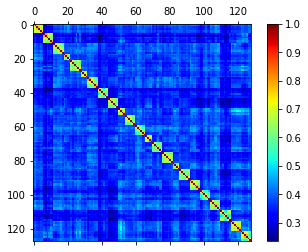

In [5]:
fig, ax = plt.subplots(figsize=(6,4))
cax = ax.matshow(np.mean(ScanScanDistMasterMat, 2), cmap = 'jet')
# ax.set_title('From R Get R')
fig.colorbar(cax)

In [7]:
## This analysis is intended to compute the mean within-subjects variability of each common nodes' conectivity profile
## to all other nodes. For each node, you isolate the similarity in connectivity profile between each scan for each subject
## and then take the mean and store that value. The result is a similarity score for each node. 

i1 = [0, 6, 12, 18, 22, 28, 32, 38, 44, 50, 54, 60, 66, 70, 76, 82, 86, 92, 98, 104, 110, 116, 122]
i2 = [6, 12, 18, 22, 28, 32, 38, 44, 50, 54, 60, 66, 70, 76, 82, 86, 92, 98, 104, 110, 116, 122, 128]

withinSubsNodeSimilarity = np.zeros((1,352))
for node in range(ScanScanDistMasterMat.shape[2]):
    tmpvec = []
    for sub in range(len(i2)):
        lowerT = np.tril(ScanScanDistMasterMat[i1[sub]:i2[sub], i1[sub]:i2[sub], node],-1)
        tmpvec.append(np.mean([x for x in lowerT.flatten() if x != 0]))
    withinSubsNodeSimilarity[0,node] = np.mean(tmpvec)
    
    
sortedMat = np.sort(withinSubsNodeSimilarity)[0]
bot10 = sortedMat[0:10]
top10 = sortedMat[-10:]

b10LocVec = []
t10LocVec = []
for i in range(10):
    b10LocVec.append(np.where(withinSubsNodeSimilarity==bot10[i])[1][0])
    t10LocVec.append(np.where(withinSubsNodeSimilarity==top10[i])[1][0])
    
## Identify which nodes are which given the names provided on https://github.com/brainspaces/schaefer400

bot10Names = commonNodeNames[np.array(b10LocVec)]
top10Names = commonNodeNames[np.array(t10LocVec)]

# np.savetxt('/Users/Eichenbaum/HWNI/Experiments/despolarity_collab/dynamic_FC/data/derivatives/preproc_32p_.01-.1/Group-level/bottom10VariableConnectivityWithinSubs.txt', bot10Names.tolist(), delimiter = ' ', fmt='%s')
# np.savetxt('/Users/Eichenbaum/HWNI/Experiments/despolarity_collab/dynamic_FC/data/derivatives/preproc_32p_.01-.1/Group-level/top10VariableConnectivityWithinSubs.txt', top10Names.tolist(), delimiter = ' ', fmt='%s')

In [8]:
bot10Names.tolist()

['Left_ContB_PFClv_2',
 'Left_SomMotA_19',
 'Right_DefaultA_PFCm_5',
 'Left_SalVentAttnB_PFCv_1',
 'Right_ContB_PFClv_3',
 'Left_SalVentAttnA_FrMed_3',
 'Left_DefaultB_PFCd_2',
 'Right_DefaultB_PFCd_5',
 'Left_SomMotA_16',
 'Left_SalVentAttnB_PFCl_1']

In [9]:
top10Names.tolist()

['Right_SomMotB_S2_2',
 'Left_DefaultA_IPL_1',
 'Left_SalVentAttnA_ParOper_1',
 'Right_SalVentAttnA_ParOper_2',
 'Left_DefaultA_IPL_2',
 'Right_VisPeri_ExStrSup_5',
 'Right_SomMotB_S2_1',
 'Left_SomMotB_Aud_1',
 'Right_ContB_PFCld_2',
 'Left_DefaultB_PFCl_1']

In [10]:
## This analysis is intended to compute the mean between-subjects variability of each common nodes' conectivity profile
## to all other nodes. For each node, you isolate the similarity in connectivity profile between all scans across subjects
## and then take the mean and store that value. The result is a similarity score for each node. 

i1 = [0, 6, 12, 18, 22, 28, 32, 38, 44, 50, 54, 60, 66, 70, 76, 82, 86, 92, 98, 104, 110, 116, 122]
i2 = [6, 12, 18, 22, 28, 32, 38, 44, 50, 54, 60, 66, 70, 76, 82, 86, 92, 98, 104, 110, 116, 122, 128]

betweenSubsNodeSimilarity = np.zeros((1,352))
for node in range(ScanScanDistMasterMat.shape[2]):
    currNodeMat = ScanScanDistMasterMat[:,:, node]
    for sub in range(len(i2)):
        currNodeMat[i1[sub]:i2[sub], i1[sub]:i2[sub]] = 0
    lowerT = np.tril(currNodeMat,-1)
    betweenSubsNodeSimilarity[0,node] = np.mean([x for x in lowerT.flatten() if x != 0])    
    
sortedMat = np.sort(betweenSubsNodeSimilarity)[0]
bot10 = sortedMat[0:10]
top10 = sortedMat[-10:]

b10LocVec = []
t10LocVec = []
for i in range(10):
    b10LocVec.append(np.where(betweenSubsNodeSimilarity==bot10[i])[1][0])
    t10LocVec.append(np.where(betweenSubsNodeSimilarity==top10[i])[1][0])
    
## Identify which nodes are which given the names provided on https://github.com/brainspaces/schaefer400

bot10Names = commonNodeNames[np.array(b10LocVec)]
top10Names = commonNodeNames[np.array(t10LocVec)]

# np.savetxt('/Users/Eichenbaum/HWNI/Experiments/despolarity_collab/dynamic_FC/data/derivatives/preproc_32p_.01-.1/Group-level/bottom10VariableConnectivityBetweenSubs.txt', bot10Names.tolist(), delimiter = ' ', fmt='%s')
# np.savetxt('/Users/Eichenbaum/HWNI/Experiments/despolarity_collab/dynamic_FC/data/derivatives/preproc_32p_.01-.1/Group-level/top10VariableConnectivityBetweenSubs.txt', top10Names.tolist(), delimiter = ' ', fmt='%s')

In [11]:
bot10Names.tolist()

['Left_SalVentAttnB_PFCv_1',
 'Right_ContC_Cingp_1',
 'Right_SalVentAttnB_PFCv_1',
 'Left_DefaultB_PFCd_6',
 'Left_DorsAttnA_SPL_3',
 'Left_ContC_Cingp_1',
 'Left_ContA_Temp_1',
 'Right_DorsAttnA_SPL_4',
 'Left_DefaultB_PFCd_2',
 'Right_DefaultA_PFCm_5']

In [12]:
top10Names.tolist()

['Left_SalVentAttnA_Ins_5',
 'Right_VisPeri_ExStrSup_5',
 'Right_DefaultA_IPL_2',
 'Left_SalVentAttnA_ParOper_1',
 'Left_DefaultA_IPL_1',
 'Left_SomMotB_Aud_1',
 'Left_DefaultB_PFCl_1',
 'Right_ContB_PFCld_2',
 'Right_SomMotB_S2_2',
 'Left_DefaultA_IPL_2']

In [29]:
## Compute the nodal cohesion matrices in order to look at nodal variability WITHOUT ACCOUNTING FOR MISSING ROIS
## This will result in all 400 nodes have a value and be represented. 
missingROIsFName = '/Users/Eichenbaum/HWNI/Experiments/despolarity_collab/dynamic_FC/data/analyses/missingROIs_list_thresh-0.25_Schaefer400node.npy'
commonROIsFName = '/Users/Eichenbaum/HWNI/Experiments/despolarity_collab/dynamic_FC/data/analyses/commonROIs_list_thresh-0.25_Schaefer400node.npy'

missingROIs = np.load(missingROIsFName)
commonROIs = np.load(commonROIsFName)
sublist = get_sublist(subdir)

nScans = 128
NodeNodeMasterMat = np.zeros((400, 400, nScans)) * np.nan
ScanScanDistMasterMatYESMISS = np.zeros((nScans, nScans, 400)) * np.nan
tmpscanXnodemat = np.zeros((nScans, 400))

### Step One: Build a matrix that contains all 352 scan x scan nodal distance matrices ###
tmp = 0
for sub in sublist:
    seslist = get_seslist(subdir, sub)
    for ses in seslist:
        for run in ['001', '002']:
            corrmatpath = '%s/sub-%s/ses-%s/func/sub-%s_ses-%s_task-rest_run-%s_bold_space-T1w_Schaefer400_corrmat.npy' %(subdir, sub, ses, sub, ses, run)
            corrmat = np.load(corrmatpath)
            
            NodeNodeMasterMat[:,:,tmp] = corrmat
            tmp+=1

    
for node in range(NodeNodeMasterMat.shape[0]):
    for scan in range(nScans):
        tmpscanXnodemat[scan,:] = NodeNodeMasterMat[node,:,scan]
        
    ScanScanDistMasterMatYESMISS[:,:,node] = np.corrcoef(tmpscanXnodemat)

outFname = '%s/Group-level/scan_x_scan_distMat_for_all_commonNodes_3D_matrix.npy' %(subdir)
# np.save(outFname, ScanScanDistMasterMat)

nodeNameFname = '/Users/Eichenbaum/HWNI/Experiments/despolarity_collab/dynamic_FC/data/resources/parcellations/Schaefer_2018/400node/schaefer400NodeNames.txt'
nodeNames = pd.read_csv(nodeNameFname, sep=' ', header = None).values
nodeNames1D = np.squeeze(nodeNames)
commonNodeNames = np.squeeze(nodeNames1D[np.array([commonROIs])])

## This analysis is intended to compute the mean within-subjects variability of each common nodes' conectivity profile
## to all other nodes. For each node, you isolate the similarity in connectivity profile between each scan for each subject
## and then take the mean and store that value. The result is a similarity score for each node. 

i1 = [0, 6, 12, 18, 22, 28, 32, 38, 44, 50, 54, 60, 66, 70, 76, 82, 86, 92, 98, 104, 110, 116, 122]
i2 = [6, 12, 18, 22, 28, 32, 38, 44, 50, 54, 60, 66, 70, 76, 82, 86, 92, 98, 104, 110, 116, 122, 128]

withinSubsNodeSimilarity = np.zeros((1,400))
for node in range(ScanScanDistMasterMatYESMISS.shape[2]):
    tmpvecW = []
    for sub in range(len(i2)):
        lowerT = np.tril(ScanScanDistMasterMatYESMISS[i1[sub]:i2[sub], i1[sub]:i2[sub], node],-1)
        tmpvecW.append(np.mean([x for x in lowerT.flatten() if x != 0]))
    withinSubsNodeSimilarity[0,node] = np.mean(tmpvecW)
    
sortedMatW = np.sort(withinSubsNodeSimilarity)[0]


## This analysis is intended to compute the mean between-subjects variability of each common nodes' conectivity profile
## to all other nodes. For each node, you isolate the similarity in connectivity profile between all scans across subjects
## and then take the mean and store that value. The result is a similarity score for each node. 

i1 = [0, 6, 12, 18, 22, 28, 32, 38, 44, 50, 54, 60, 66, 70, 76, 82, 86, 92, 98, 104, 110, 116, 122]
i2 = [6, 12, 18, 22, 28, 32, 38, 44, 50, 54, 60, 66, 70, 76, 82, 86, 92, 98, 104, 110, 116, 122, 128]

betweenSubsNodeSimilarity = np.zeros((1,400))
for node in range(ScanScanDistMasterMatYESMISS.shape[2]):
    currNodeMat = ScanScanDistMasterMatYESMISS[:,:, node]
    for sub in range(len(i2)):
        currNodeMat[i1[sub]:i2[sub], i1[sub]:i2[sub]] = 0
    lowerT = np.tril(currNodeMat,-1)
    betweenSubsNodeSimilarity[0,node] = np.mean([x for x in lowerT.flatten() if x != 0])    
    
sortedMatB = np.sort(betweenSubsNodeSimilarity)[0]

In [19]:
## Load the atlas
atlas_img = image.load_img('/Users/Eichenbaum/HWNI/Experiments/despolarity_collab/dynamic_FC/data/resources/parcellations/Schaefer_2018/400node/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.nii.gz')

In [20]:
## Conver the atlas to 4D
img_stack = []
atlas_data = atlas_img.get_data()
for idx in range(1,401):
    roi_img = atlas_data == idx
    img_stack.append(roi_img)
img_stack = np.array(img_stack)

In [21]:
img_list = []
for idx in range(400):
    roi_img = image.new_img_like(atlas_img, img_stack[idx])
    img_list.append(roi_img)

In [22]:
atlas_4D = image.concat_imgs(img_list)

In [23]:
specialVarwithZscoreStuff = stats.zscore(withinSubsNodeSimilarity[0])
atlas_4D_nodeVar = regions.signals_to_img_maps(specialVarwithZscoreStuff, atlas_4D)

/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


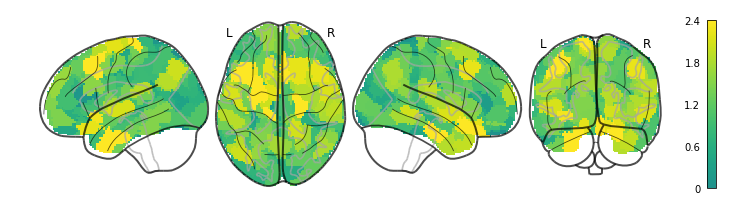

In [24]:
plotting.plot_glass_brain(atlas_4D_nodeVar, display_mode='lzry', cmap='viridis', colorbar=True)

In [25]:
specialVarwithZscoreStuff = stats.zscore(betweenSubsNodeSimilarity[0])
atlas_4D_nodeVar = regions.signals_to_img_maps(specialVarwithZscoreStuff, atlas_4D)

/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


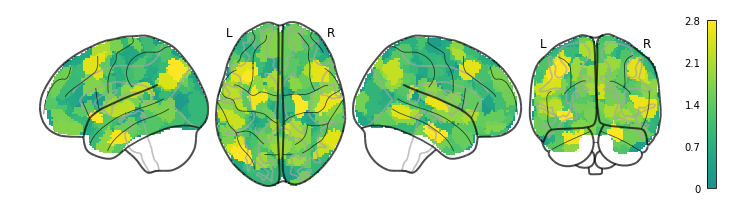

In [26]:
plotting.plot_glass_brain(atlas_4D_nodeVar, display_mode='lzry', cmap='viridis', colorbar=True)